In [52]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC, LinearSVC

In [2]:
# import data
data = pd.read_csv('hcp_drug_prediction_data_cleaned.csv')
print(data)

      Subject  PSQI_Score  PicSeq_AgeAdj  CardSort_AgeAdj  Flanker_AgeAdj  \
0      100004           8         112.44            88.64          111.01   
1      100206           6         118.78           104.94          116.55   
2      100307           4         103.45           109.92          101.90   
3      100408           4         125.19           100.77          113.51   
4      100610           4         101.69           115.18          114.18   
5      101006           2          70.00            94.30           92.33   
6      101107           9          97.37           105.69           96.19   
7      101208           6          95.64            82.44           84.46   
8      101309           5          93.36            86.03          103.37   
9      101410           8         111.31           106.84          100.58   
10     101612           4         101.54            96.84          108.32   
11     101915           6          84.96            90.94           89.10   

In [3]:
data["Age_recoded"] = data["Age_recoded"].astype('category')
data["Gender_recoded"] = data["Gender_recoded"].astype('category')
data["sub_use"] = data["sub_use"].astype('category')

In [4]:
print(data.shape)

(1169, 75)


In [5]:
print(data.dtypes)

Subject                 int64
PSQI_Score              int64
PicSeq_AgeAdj         float64
CardSort_AgeAdj       float64
Flanker_AgeAdj        float64
PMAT24_A_CR           float64
PMAT24_A_SI           float64
PMAT24_A_RTCR         float64
ReadEng_AgeAdj        float64
PicVocab_AgeAdj       float64
ProcSpeed_AgeAdj      float64
DDisc_SV_1mo_200      float64
DDisc_SV_6mo_200      float64
DDisc_SV_1yr_200      float64
DDisc_SV_3yr_200      float64
DDisc_SV_5yr_200      float64
DDisc_SV_10yr_200     float64
DDisc_SV_1mo_40K      float64
DDisc_SV_6mo_40K      float64
DDisc_SV_1yr_40K      float64
DDisc_SV_3yr_40K      float64
DDisc_SV_5yr_40K      float64
DDisc_SV_10yr_40K     float64
DDisc_AUC_200         float64
DDisc_AUC_40K         float64
VSPLOT_TC             float64
VSPLOT_CRTE           float64
VSPLOT_OFF            float64
SCPT_TP               float64
SCPT_TN               float64
                       ...   
ER40ANG               float64
ER40FEAR              float64
ER40HAP   

In [23]:
# generate random subsample of HCs with equal N to sub use 
data_hc = data[data['sub_use']== 0]
data_su = data[data['sub_use']== 1]

print(data_hc.shape)

hc_rand = data_hc.sample(286, random_state=999)
print(hc_rand)
print(hc_rand.shape)

(883, 75)
      Subject  PSQI_Score  PicSeq_AgeAdj  CardSort_AgeAdj  Flanker_AgeAdj  \
103    120010           3         130.24           116.76          107.86   
709    362034           6         111.31            81.23           72.42   
548    205826           3         106.96           104.08           96.02   
1144   959574           3          94.10            90.09           88.46   
686    336841           7         112.44           119.60          117.22   
779    469961           7         114.88           109.81           99.24   
913    644246           3          93.32            92.85           83.55   
702    355239           4          91.63            89.10           99.50   
626    250932           3         117.41           104.06           93.62   
547    205725           1         103.49           119.65          118.80   
78     115017           3         120.31            96.73           95.53   
719    377451          19         110.97            92.75         

In [28]:
# concatenate DFs
dfs = [hc_rand,data_su]
data_rand = pd.concat(dfs)
print(data_rand)

      Subject  PSQI_Score  PicSeq_AgeAdj  CardSort_AgeAdj  Flanker_AgeAdj  \
103    120010           3         130.24           116.76          107.86   
709    362034           6         111.31            81.23           72.42   
548    205826           3         106.96           104.08           96.02   
1144   959574           3          94.10            90.09           88.46   
686    336841           7         112.44           119.60          117.22   
779    469961           7         114.88           109.81           99.24   
913    644246           3          93.32            92.85           83.55   
702    355239           4          91.63            89.10           99.50   
626    250932           3         117.41           104.06           93.62   
547    205725           1         103.49           119.65          118.80   
78     115017           3         120.31            96.73           95.53   
719    377451          19         110.97            92.75           89.45   

In [45]:
#array = dataframe.values
X = data_rand.drop(['Subject','sub_use','Gender_recoded'], axis = 1)
y = data_rand.loc[:,'sub_use']

In [46]:
print(X.shape)
print(X.iloc[:,0:71])

(572, 72)
      PSQI_Score  PicSeq_AgeAdj  CardSort_AgeAdj  Flanker_AgeAdj  PMAT24_A_CR  \
103            3         130.24           116.76          107.86         24.0   
709            6         111.31            81.23           72.42         15.0   
548            3         106.96           104.08           96.02         17.0   
1144           3          94.10            90.09           88.46         16.0   
686            7         112.44           119.60          117.22         19.0   
779            7         114.88           109.81           99.24         22.0   
913            3          93.32            92.85           83.55         21.0   
702            4          91.63            89.10           99.50          8.0   
626            3         117.41           104.06           93.62         19.0   
547            1         103.49           119.65          118.80         20.0   
78             3         120.31            96.73           95.53         15.0   
719           19  

In [47]:
# pull out continuous vars
X_con = X.iloc[:,0:71]

# standardize continuous vars
scaler = StandardScaler()
X.iloc[:,0:71] = scaler.fit_transform(X_con)

#X_f1 = X.loc[:,'PMAT24_A_SI']
#X_AngAgg = X.loc[:,'AngAggr_Unadj']
#X_DD1 = X.loc[:,'DDisc_SV_1mo_200']
#X_NEO_E = X.loc[:,'NEOFAC_E']

In [33]:
print(X)

      PSQI_Score  PicSeq_AgeAdj  CardSort_AgeAdj  Flanker_AgeAdj  PMAT24_A_CR  \
103    -0.706185       1.548945         1.498647        0.639638     1.498049   
709     0.304502       0.400189        -2.131982       -2.954759    -0.359359   
548    -0.706185       0.136212         0.202942       -0.561199     0.053399   
1144   -0.706185      -0.644189        -1.226624       -1.327949    -0.152980   
686     0.641397       0.468763         1.788852        1.588948     0.466156   
779     0.641397       0.616832         0.788462       -0.234620     1.085292   
913    -0.706185      -0.691523        -0.944594       -1.825932     0.878913   
702    -0.369289      -0.794080        -1.327787       -0.208250    -1.804009   
626    -0.706185       0.770364         0.200899       -0.804612     0.466156   
547    -1.379976      -0.074363         1.793961        1.749195     0.672535   
78     -0.706185       0.946349        -0.548116       -0.610896    -0.359359   
719     4.684143       0.379

In [34]:
print(X_con)

      PSQI_Score  PicSeq_AgeAdj  CardSort_AgeAdj  Flanker_AgeAdj  PMAT24_A_CR  \
103            3         130.24           116.76          107.86         24.0   
709            6         111.31            81.23           72.42         15.0   
548            3         106.96           104.08           96.02         17.0   
1144           3          94.10            90.09           88.46         16.0   
686            7         112.44           119.60          117.22         19.0   
779            7         114.88           109.81           99.24         22.0   
913            3          93.32            92.85           83.55         21.0   
702            4          91.63            89.10           99.50          8.0   
626            3         117.41           104.06           93.62         19.0   
547            1         103.49           119.65          118.80         20.0   
78             3         120.31            96.73           95.53         15.0   
719           19         110

In [48]:
# logistic regression with single feature 
log_reg = LogisticRegression(penalty = 'l1', solver = 'liblinear', class_weight='balanced')
# rfecv = RFECV(log_reg, step = 1, cv = StratifiedKFold(5), scoring = 'accuracy')
rfecv = RFECV(log_reg, step = 1, cv = StratifiedKFold(5), scoring = 'accuracy')
rfecv.fit(X,y)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                                   fit_intercept=True, intercept_scaling=1,
                                   l1_ratio=None, max_iter=100,
                                   multi_class='warn', n_jobs=None,
                                   penalty='l1', random_state=None,
                                   solver='liblinear', tol=0.0001, verbose=0,
                                   warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

Optimal number of features : 14


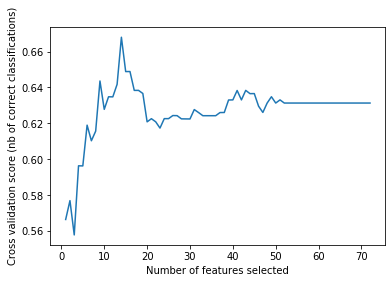

In [49]:
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [50]:
print(rfecv.support_.sum())
print(rfecv.support_)
X_columns = X.columns
print(X_columns)

X_columns[rfecv.support_]

14
[False False  True False False  True False False False False False False
 False False False False  True False  True False False  True False False
  True False False False False False False False False False False False
  True False  True False False False False False  True False False False
 False  True False  True False False False False False False False False
 False False False False False  True False False  True False  True False]
Index(['PSQI_Score', 'PicSeq_AgeAdj', 'CardSort_AgeAdj', 'Flanker_AgeAdj',
       'PMAT24_A_CR', 'PMAT24_A_SI', 'PMAT24_A_RTCR', 'ReadEng_AgeAdj',
       'PicVocab_AgeAdj', 'ProcSpeed_AgeAdj', 'DDisc_SV_1mo_200',
       'DDisc_SV_6mo_200', 'DDisc_SV_1yr_200', 'DDisc_SV_3yr_200',
       'DDisc_SV_5yr_200', 'DDisc_SV_10yr_200', 'DDisc_SV_1mo_40K',
       'DDisc_SV_6mo_40K', 'DDisc_SV_1yr_40K', 'DDisc_SV_3yr_40K',
       'DDisc_SV_5yr_40K', 'DDisc_SV_10yr_40K', 'DDisc_AUC_200',
       'DDisc_AUC_40K', 'VSPLOT_TC', 'VSPLOT_CRTE', 'VSPLOT_OFF', 'SCPT_TP',
 

Index(['CardSort_AgeAdj', 'PMAT24_A_SI', 'DDisc_SV_1mo_40K',
       'DDisc_SV_1yr_40K', 'DDisc_SV_10yr_40K', 'VSPLOT_TC', 'IWRD_RTC',
       'CogFluidComp_AgeAdj', 'ER40ANG', 'AngAffect_Unadj', 'AngAggr_Unadj',
       'SelfEff_Unadj', 'NEOFAC_C', 'NEOFAC_E'],
      dtype='object')

In [57]:
list(X_columns[rfecv.support_])

['CardSort_AgeAdj',
 'PMAT24_A_SI',
 'DDisc_SV_1mo_40K',
 'DDisc_SV_1yr_40K',
 'DDisc_SV_10yr_40K',
 'VSPLOT_TC',
 'IWRD_RTC',
 'CogFluidComp_AgeAdj',
 'ER40ANG',
 'AngAffect_Unadj',
 'AngAggr_Unadj',
 'SelfEff_Unadj',
 'NEOFAC_C',
 'NEOFAC_E']

In [53]:
svc = SVC(kernel = 'linear', class_weight='balanced')
rfecv_svc = RFECV(svc, step = 1, cv = StratifiedKFold(5), scoring = 'accuracy')
rfecv_svc.fit(X,y)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
                    decision_function_shape='ovr', degree=3,
                    gamma='auto_deprecated', kernel='linear', max_iter=-1,
                    probability=False, random_state=None, shrinking=True,
                    tol=0.001, verbose=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

Optimal number of features : 33


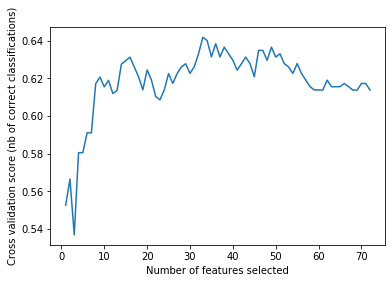

In [54]:
print("Optimal number of features : %d" % rfecv_svc.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv_svc.grid_scores_) + 1), rfecv_svc.grid_scores_)
plt.show()

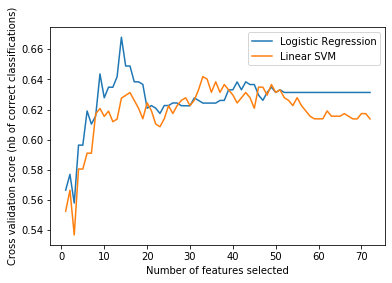

In [55]:
# Plot number of features VS. cross-validation scores for the svm and logistic regression models
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1,len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, label = 'Logistic Regression')
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv_svc.grid_scores_, label = 'Linear SVM')
plt.legend()
plt.show()

In [56]:
X.corrwith(y).sort_values()

VSPLOT_OFF              -0.162438
PMAT24_A_SI             -0.140582
NEOFAC_C                -0.108514
NEOFAC_A                -0.095018
SCPT_FN                 -0.054295
ER40HAP                 -0.052124
DDisc_SV_6mo_200        -0.044691
IWRD_TOT                -0.043492
DDisc_SV_10yr_40K       -0.043303
DDisc_SV_1mo_200        -0.038562
DDisc_SV_5yr_200        -0.037943
DDisc_SV_3yr_200        -0.037843
DDisc_AUC_200           -0.037239
DDisc_SV_10yr_200       -0.035257
DDisc_SV_1mo_40K        -0.027911
PicSeq_AgeAdj           -0.027536
MeanPurp_Unadj          -0.022649
SCPT_FP                 -0.016927
DDisc_SV_5yr_40K        -0.015712
DDisc_SV_1yr_200        -0.007932
InstruSupp_Unadj        -0.007357
DDisc_AUC_40K           -0.004011
ER40NOE                 -0.001319
DDisc_SV_3yr_40K         0.000510
SCPT_LRNR                0.001718
Flanker_AgeAdj           0.003988
Loneliness_Unadj         0.004742
ProcSpeed_AgeAdj         0.008462
SCPT_TPRT                0.008546
PercReject_Una

In [65]:
# np.array(np.where(rfecv.ranking_==1))

cols = np.array(X.columns)
print(cols)

['PSQI_Score' 'PicSeq_AgeAdj' 'CardSort_AgeAdj' 'Flanker_AgeAdj'
 'PMAT24_A_CR' 'PMAT24_A_SI' 'PMAT24_A_RTCR' 'ReadEng_AgeAdj'
 'PicVocab_AgeAdj' 'ProcSpeed_AgeAdj' 'DDisc_SV_1mo_200'
 'DDisc_SV_6mo_200' 'DDisc_SV_1yr_200' 'DDisc_SV_3yr_200'
 'DDisc_SV_5yr_200' 'DDisc_SV_10yr_200' 'DDisc_SV_1mo_40K'
 'DDisc_SV_6mo_40K' 'DDisc_SV_1yr_40K' 'DDisc_SV_3yr_40K'
 'DDisc_SV_5yr_40K' 'DDisc_SV_10yr_40K' 'DDisc_AUC_200' 'DDisc_AUC_40K'
 'VSPLOT_TC' 'VSPLOT_CRTE' 'VSPLOT_OFF' 'SCPT_TP' 'SCPT_TN' 'SCPT_FP'
 'SCPT_FN' 'SCPT_TPRT' 'SCPT_SEN' 'SCPT_SPEC' 'SCPT_LRNR' 'IWRD_TOT'
 'IWRD_RTC' 'ListSort_AgeAdj' 'CogFluidComp_AgeAdj' 'CogEarlyComp_AgeAdj'
 'CogTotalComp_AgeAdj' 'CogCrystalComp_AgeAdj' 'ER40_CR' 'ER40_CRT'
 'ER40ANG' 'ER40FEAR' 'ER40HAP' 'ER40NOE' 'ER40SAD' 'AngAffect_Unadj'
 'AngHostil_Unadj' 'AngAggr_Unadj' 'FearAffect_Unadj' 'FearSomat_Unadj'
 'Sadness_Unadj' 'LifeSatisf_Unadj' 'MeanPurp_Unadj' 'PosAffect_Unadj'
 'Friendship_Unadj' 'Loneliness_Unadj' 'PercHostil_Unadj'
 'PercReject_Unad

In [67]:
idx = np.where(rfecv.ranking_ == 1)[0]
idx = idx.tolist()
print(idx)

[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 16, 18, 21, 24, 26, 31, 32, 34, 36, 37, 38, 39, 40, 43, 44, 46, 49, 51, 52, 53, 55, 56, 57, 59, 62, 64, 65, 67, 68, 69, 70, 71, 72]


In [68]:
ranked_features = cols[idx]
print(ranked_features)

['PSQI_Score' 'PicSeq_AgeAdj' 'CardSort_AgeAdj' 'Flanker_AgeAdj'
 'PMAT24_A_CR' 'PMAT24_A_SI' 'ReadEng_AgeAdj' 'PicVocab_AgeAdj'
 'ProcSpeed_AgeAdj' 'DDisc_SV_1mo_200' 'DDisc_SV_6mo_200'
 'DDisc_SV_1yr_200' 'DDisc_SV_3yr_200' 'DDisc_SV_5yr_200'
 'DDisc_SV_1mo_40K' 'DDisc_SV_1yr_40K' 'DDisc_SV_10yr_40K' 'VSPLOT_TC'
 'VSPLOT_OFF' 'SCPT_TPRT' 'SCPT_SEN' 'SCPT_LRNR' 'IWRD_RTC'
 'ListSort_AgeAdj' 'CogFluidComp_AgeAdj' 'CogEarlyComp_AgeAdj'
 'CogTotalComp_AgeAdj' 'ER40_CRT' 'ER40ANG' 'ER40HAP' 'AngAffect_Unadj'
 'AngAggr_Unadj' 'FearAffect_Unadj' 'FearSomat_Unadj' 'LifeSatisf_Unadj'
 'MeanPurp_Unadj' 'PosAffect_Unadj' 'Loneliness_Unadj' 'EmotSupp_Unadj'
 'PercStress_Unadj' 'SelfEff_Unadj' 'NEOFAC_O' 'NEOFAC_C' 'NEOFAC_N'
 'NEOFAC_E' 'Age_recoded' 'Gender_recoded']
